In [1]:
import h5py
import numpy as np
import matlab.engine
import sys
import matplotlib.pyplot as plt
import math
import torch

In [2]:
eng = matlab.engine.start_matlab()
sys.path.append("C:\\Users\\rodrigo\\Documents\\MRS\\Gannet")

In [3]:
mrs_struct = eng.load(f"gannet_acc_load/g4_s01.mat")["mrs_struct"]
base_spec = torch.real(torch.from_numpy(np.array(mrs_struct["spec"]["vox1"]["GABAGlx"]["diff"]).flatten()))
base_freq = torch.from_numpy(np.array(mrs_struct["spec"]["freq"]).flatten())

In [4]:
with h5py.File("indiv/g4_s01.h5") as hf:
    target = torch.from_numpy(hf["target"][()])
    transient_specs = torch.from_numpy(hf["transient_specs"][()])

diff_spec = torch.real(transient_specs[:,1]-transient_specs[:,0]).mean(axis=1)

In [6]:
base_spec.dtype

torch.float64

In [7]:
target.dtype

torch.complex128

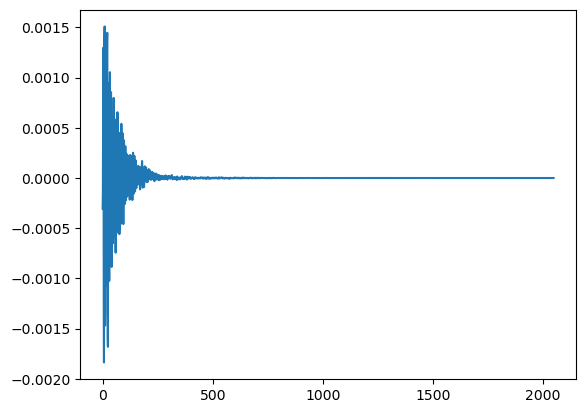

In [10]:
a = torch.fft.ifft(torch.fft.ifftshift(diff_spec,axis=0),axis=0)
b = torch.fft.fftshift(torch.fft.fft(a))
plt.plot(torch.real(a))
plt.show()

In [5]:
#### constants for resizing data

ref_sw = 2000
ref_npoints = 2048
ref_larmor_freq = 127.758139
ref_hr_npoints = 32768
ref_freq_range = ref_sw/ref_larmor_freq
ref_freq_short = 4.68 + (ref_npoints + 1 -torch.arange(1,ref_npoints+1))/ref_npoints*ref_freq_range -ref_freq_range/2
ref_freq_long = 4.68 + (ref_hr_npoints + 1 -torch.arange(1,ref_hr_npoints+1))/ref_hr_npoints*ref_freq_range -ref_freq_range/2

####

def ref_spec_to_hr_spec_interpolate(in_spec,base_spec,base_freq):
    rewrite_array = [torch.argmin(torch.abs(ref_freq_short[i]-base_freq)) for i in range(ref_freq_short.shape[0])]
    out_array = base_spec.clone()
    for i in range(len(rewrite_array)-1):
        init_i = rewrite_array[i]
        stop_i = rewrite_array[i+1]-1
        stretch = in_spec[i] +torch.arange(0,stop_i-init_i+1)*(in_spec[i+1]-in_spec[i])/(stop_i-init_i)
        out_array[init_i:stop_i+1]=stretch
    
    return out_array

In [6]:
out = ref_spec_to_hr_spec_interpolate(target,base_spec,base_freq)
out2 = ref_spec_to_hr_spec_interpolate(diff_spec,base_spec,base_freq)

C:\Users\rodrigo\AppData\Local\Temp\ipykernel_24584\864022052.py:20: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:276.)
  out_array[init_i:stop_i+1]=stretch


c:\Users\rodrigo\anaconda3\envs\thesis\lib\site-packages\torch\_tensor.py:972: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


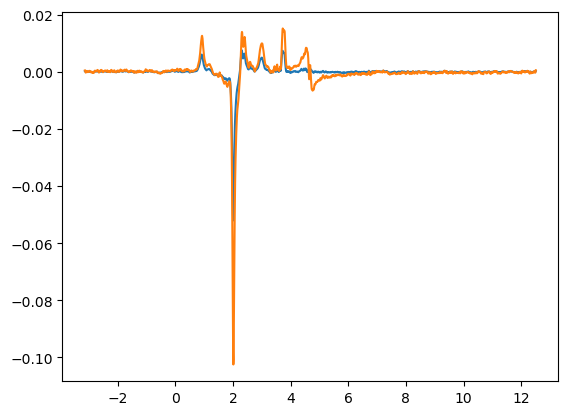

In [7]:
plt.plot(ref_freq_short,target)
plt.plot(ref_freq_short,diff_spec)
#plt.xlim(2.8,3.2)
plt.show()

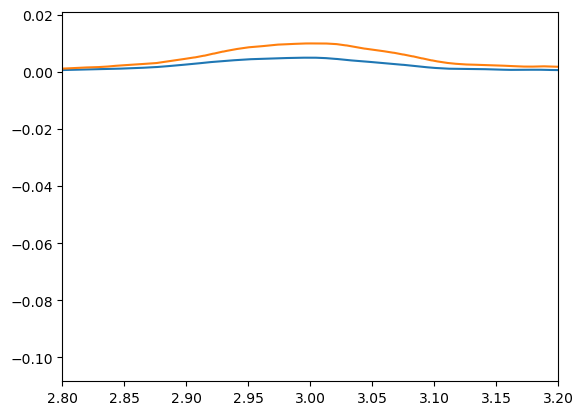

In [8]:
plt.plot(base_freq,out)
plt.plot(base_freq,out2)
plt.xlim(2.8,3.2)
plt.show()

In [2]:
eng = matlab.engine.start_matlab()
sys.path.append("C:\\Users\\rodrigo\\Documents\\MRS\\Gannet")

In [3]:
mrs_struct = eng.load("c:/Users/rodrigo/Documents/thesis/data/gannet_full_load/g7_s01.mat")["mrs_struct"]

In [4]:
mrs_struct.keys()

dict_keys(['version', 'ii', 'metabfile', 'p', 'fids', 'spec', 'out'])

In [6]:
print(mrs_struct["p"].keys())
print(mrs_struct["p"]["dt"])

dict_keys(['target', 'seqorig', 'LB', 'water_ECC', 'metab_ECC', 'water_removal', 'alignment', 'use_prealign_ref', 'vox', 'fit_resid_water', 'weighted_averaging', 'HERMES', 'HERCULES', 'PRIAM', 'phantom', 'join', 'mat', 'csv', 'append', 'hide', 'vendor', 'reference', 'numScans', 'numFilesPerScan', 'GE', 'LarmorFreq', 'sw', 'npoints', 'nrows', 'TE', 'TR', 'voxdim', 'Navg', 'Nwateravg', 'nrows_water', 'ZeroFillTo', 'zf', 'dt', 'SpecRes', 'SpecResNominal', 'Tacq', 'weighted_averaging_method'])
0.0005


In [ ]:
zero_fill_to = (32768/2000 * sw)

In [39]:
dt = float(mrs_struct["p"]["dt"])
sw = float(mrs_struct["p"]["sw"])
npoints = int(mrs_struct["p"]["npoints"])
larmor_freq = float(mrs_struct["p"]["LarmorFreq"])
zero_fill = int(mrs_struct["p"]["ZeroFillTo"])
lb = float(mrs_struct["p"]["LB"])

In [9]:
freq_range = sw/larmor_freq
print(freq_range)

15.654579940304234


In [23]:
freq = 4.68 + (zero_fill + 1 -np.arange(1,zero_fill+1))/zero_fill*freq_range -freq_range/2
freq_og = 4.68 + (npoints + 1 -np.arange(1,npoints+1))/npoints*freq_range -freq_range/2
t = np.arange(1,npoints+1)/sw

In [13]:
freq

array([12.50728997, 12.50681223, 12.50633449, ..., -3.14585675,
       -3.14633449, -3.14681223])

In [18]:
data = np.array(mrs_struct["fids"]["data"])

In [25]:
ft_data = data*np.exp(-t.reshape(-1,1)*lb*math.pi)
ft_data = np.fft.fftshift(np.fft.fft(ft_data,zero_fill,axis=0),axes=0)

spec_data = data*np.exp(-t.reshape(-1,1)*lb*math.pi)
spec_data = np.fft.fftshift(np.fft.fft(spec_data,npoints,axis=0),axes=0)

In [26]:
file_spec = np.array(mrs_struct["spec"]["AllFramesFT"])[:,0]

In [31]:
ft_data.shape

(32768, 320)

In [32]:
spec_data.shape

(2048, 320)

c:\Users\rodrigo\anaconda3\envs\thesis\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


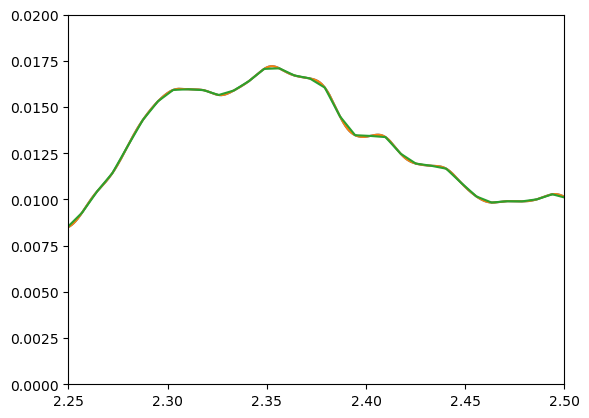

In [33]:
plt.plot(freq,ft_data[:,0])
plt.plot(freq,file_spec)
plt.plot(freq_og,spec_data[:,0])
plt.xlim(2.25,2.5)
plt.ylim(0,0.02)
plt.show()

(-3.353403438179775e-18+3.6422416731934915e-20j)


c:\Users\rodrigo\anaconda3\envs\thesis\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


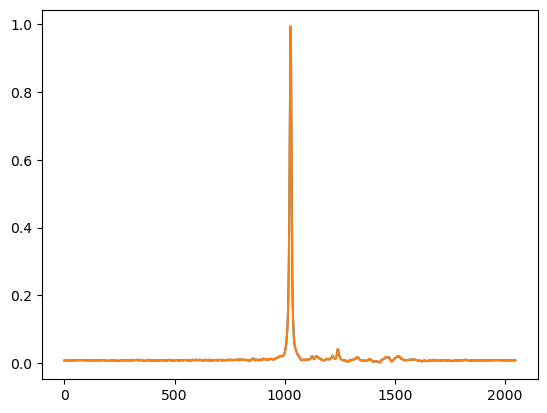

In [41]:
start_high_res = file_spec
fid_high_res = np.fft.ifft(np.fft.ifftshift(start_high_res))
new_log_res_spec = np.fft.fftshift(np.fft.fft(fid_high_res,npoints,axis=0),axes=0)
plt.plot(new_log_res_spec)
plt.plot(spec_data[:,0])

print((new_log_res_spec-spec_data[:,0]).mean())
plt.show()

In [17]:
mrs_struct["fids"].keys()

dict_keys(['data_water', 'data', 'ON_OFF', 'data_align'])

In [18]:
np.array(mrs_struct["fids"]["data"]).shape

(2048, 320)

In [19]:
np.array(mrs_struct["fids"]["data_align"]).shape

(2048, 320)

In [20]:
sample_fid = np.array(mrs_struct["fids"]["data"])[:,0]

In [26]:
file_spec = np.array(mrs_struct["spec"]["AllFramesFT"])[:,0]

In [33]:
mrs_struct["spec"]["vox1"]["GABAGlx"].keys()

dict_keys(['on', 'off', 'diff', 'diff_noalign'])

In [44]:
other_spec = np.array(mrs_struct["spec"]["vox1"]["GABAGlx"]["off"])

c:\Users\rodrigo\anaconda3\envs\thesis\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


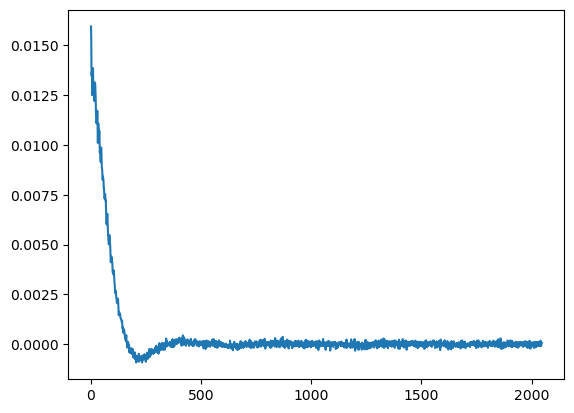

In [27]:
plt.plot(sample_fid)
plt.show()

In [ ]:
other_spec

In [40]:
other_spec.shape

(1, 32768)

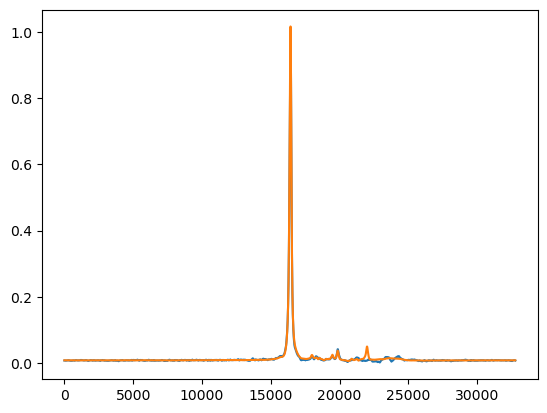

In [45]:
plt.plot(file_spec)
plt.plot(other_spec[0])
plt.show()

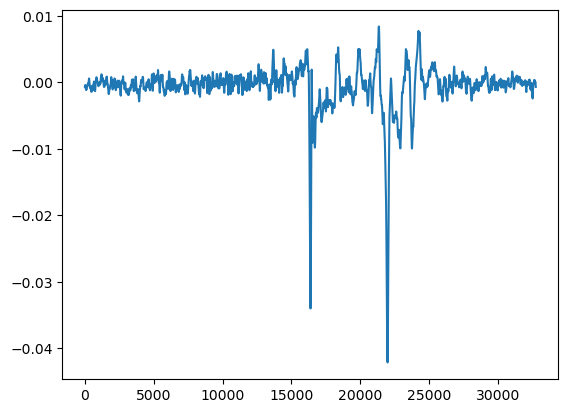

In [46]:
plt.plot(file_spec-other_spec[0])
plt.show()

In [ ]:
plt.plot(file_spec)
plt.plot(np.fft.fftshift(np.fft.fft(sample_fid)))
plt.show()

In [ ]:
#### recreating test

In [3]:
mrs_struct = eng.load("c:/Users/rodrigo/Documents/thesis/data/gannet_full_load/g7_s01.mat")["mrs_struct"]

127.758139

In [3]:
ref_sw = 2000
ref_npoints = 2048
ref_larmor_freq = 127.758139
ref_hr_npoints = 32768
ref_freq_range = ref_sw/ref_larmor_freq
ref_freq_short = 4.68 + (ref_npoints + 1 -np.arange(1,ref_npoints+1))/ref_npoints*ref_freq_range -ref_freq_range/2
ref_freq_long = 4.68 + (ref_hr_npoints + 1 -np.arange(1,ref_hr_npoints+1))/ref_hr_npoints*ref_freq_range -ref_freq_range/2

In [28]:
mrs_struct_2 = eng.load("c:/Users/rodrigo/Documents/thesis/data/gannet_acc_load/g4_s01.mat")["mrs_struct"]
fid_data_2 = np.array(mrs_struct_2["fids"]["data"])[:,0]
time_2 = np.arange(1,mrs_struct_2["p"]["npoints"]+1)/mrs_struct_2["p"]["sw"]    
fid_data_2 = fid_data_2*np.exp(-time_2*mrs_struct_2["p"]["LB"]*math.pi)

zf_2 = int(32768*mrs_struct_2["p"]["sw"]/2000)

freq_range_2 = mrs_struct_2["p"]["sw"]/mrs_struct_2["p"]["LarmorFreq"]
freq_2 = 4.68 + (zf_2 + 1 -np.arange(1,zf_2+1))/zf_2*freq_range_2 -freq_range_2/2

hr_spec_2 = np.fft.fftshift(np.fft.fft(fid_data_2,zf_2,axis=0),axes=0)

In [23]:
new_spec_2 = np.zeros(ref_hr_npoints,dtype=hr_spec_2.dtype)
for i in range(ref_hr_npoints):
    new_spec_2[i] = hr_spec_2[np.argmin(np.abs(freq_2-ref_freq_long[i]))]


In [24]:
new_hr_fid = np.fft.ifft(np.fft.ifftshift(new_spec_2))
new_lr_fid = new_hr_fid[:ref_npoints]
new_lr_spec = np.fft.fftshift(np.fft.fft(new_lr_fid))

In [25]:
newnew_lr_fid = np.fft.ifft(np.fft.ifftshift(new_lr_spec/2))
newnew_hr_spec = np.fft.fftshift(np.fft.fft(newnew_lr_fid,ref_hr_npoints))

newnew_hr_reorg_spec = hr_spec_2.copy()
for i in range(ref_hr_npoints):
    newnew_hr_reorg_spec[np.argmin(np.abs(freq_2-ref_freq_long[i]))] = newnew_hr_spec[i]

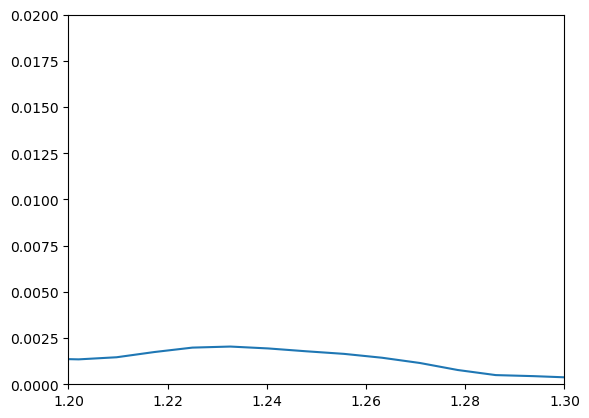

In [18]:
plt.plot(ref_freq_short,new_lr_spec)
plt.xlim(1.2,1.3)
plt.ylim(0,0.02)
plt.show()

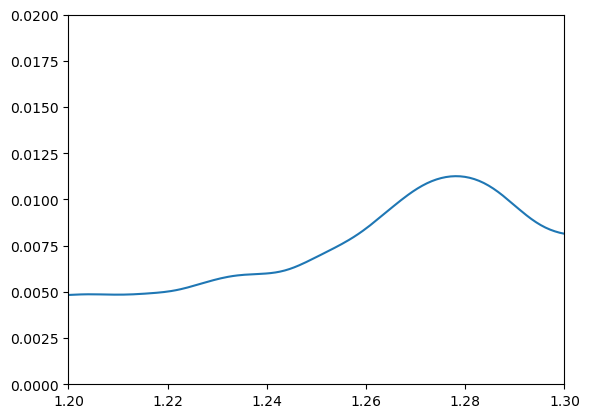

In [29]:
plt.plot(ref_freq_long,newnew_hr_spec)
plt.xlim(1.2,1.3)
plt.ylim(0,0.02)
plt.show()

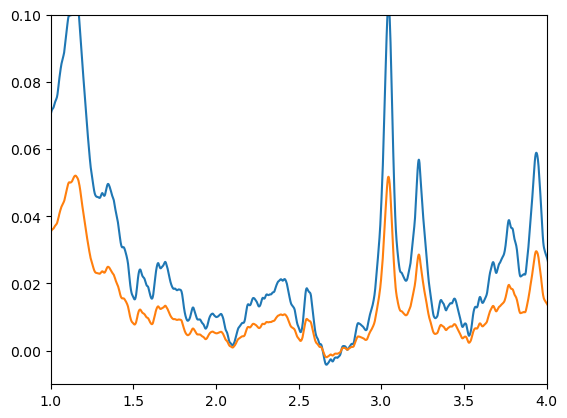

In [27]:
plt.plot(freq_2,hr_spec_2)
plt.plot(freq_2,newnew_hr_reorg_spec)
plt.xlim(1,4)
plt.ylim(-0.01,0.1)
plt.show()

In [18]:
freq_2[(freq_2.shape[0]-32768)//2+100]

12.46218155353517

In [11]:
ref_freq_long

array([12.50728997, 12.50681223, 12.50633449, ..., -3.14585675,
       -3.14633449, -3.14681223])

In [19]:
idx = np.argmin(np.abs(freq_2-ref_freq_long[0]))
print(freq_2[idx])

12.507104488074123


In [21]:
print(freq_2[idx+2])

12.506148680956276


In [ ]:
zero_fill_to = (32768/2000 * sw)
dt = float(mrs_struct["p"]["dt"])
sw = float(mrs_struct["p"]["sw"])
npoints = int(mrs_struct["p"]["npoints"])
larmor_freq = float(mrs_struct["p"]["LarmorFreq"])
zero_fill = int(mrs_struct["p"]["ZeroFillTo"])
lb = float(mrs_struct["p"]["LB"])
freq_range = sw/larmor_freq

In [1]:
##### testing library
import h5py
import numpy as np
import matlab.engine
import sys
import matplotlib.pyplot as plt
import math
import torch

import size_transforms as size_T

eng = matlab.engine.start_matlab()
sys.path.append("C:\\Users\\rodrigo\\Documents\\MRS\\Gannet")

In [2]:
mrs_struct = eng.load("c:/Users/rodrigo/Documents/thesis/data/gannet_acc_load/g4_s01.mat")["mrs_struct"]
fid_data = torch.from_numpy(np.array(mrs_struct["fids"]["data"])[:,0])
sw = float(mrs_struct["p"]["sw"])
lb = float(mrs_struct["p"]["LB"])
larmor_freq = float(mrs_struct["p"]["LarmorFreq"])

In [3]:
torch.zeros(size=(32768,),dtype = torch.complex128)

tensor([0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
       dtype=torch.complex128)

In [6]:
out = torch.zeros(size=(int(fid_data.shape[0]),),dtype=fid_data.dtype)

<class 'int'>
torch.complex128
<class 'torch.Tensor'>


c:\Users\rodrigo\anaconda3\envs\thesis\lib\site-packages\torch\_tensor.py:972: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


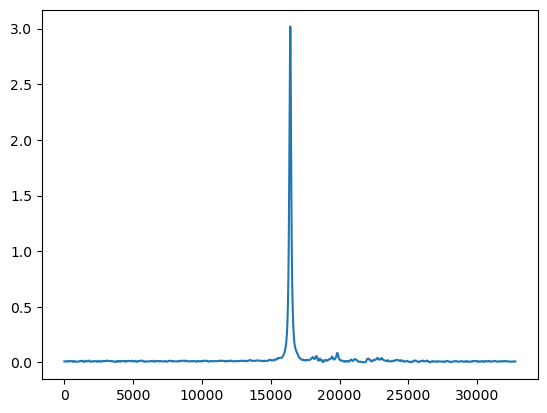

In [3]:
new_format_spec = size_T.input_fids_to_std_lr_spec(fid_data,sw,larmor_freq,lb)

c:\Users\rodrigo\anaconda3\envs\thesis\lib\site-packages\torch\_tensor.py:972: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


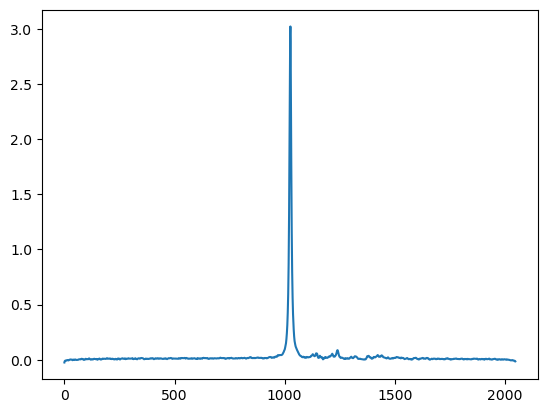

In [10]:
plt.plot(new_format_spec)
plt.show()

In [4]:
float(mrs_struct["p"]["sw"])
base_spec = torch.from_numpy(np.array(mrs_struct["spec"]["vox1"]["GABAGlx"]["diff"]))[0]
base_freq = torch.from_numpy(np.array(mrs_struct["spec"]["freq"]))[0]

In [12]:
base_freq.shape

torch.Size([81920])

In [11]:
output_pasting = size_T.ref_spec_to_hr_spec(new_format_spec,base_spec,base_freq)

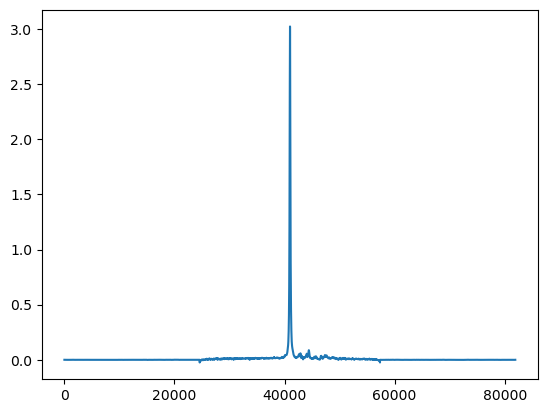

In [13]:
plt.plot(output_pasting)
#plt.xlim(40000,42500)
plt.show()